In [4]:
%load_ext autoreload
%autoreload 2

from run import *
import time
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
viz = None
reduced=True
# reduced=False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
if reduced:
    q_i= np.deg2rad([-90., 40.]) #EASY
    q_i= np.deg2rad([-170., 0.]) #NOT EASY
    q_g= np.deg2rad([-79., 64.])
else:
    q_i = np.array([1., -1.5, 2.1, -.5, -.5, 0])
    q_g = np.array([3., -1., 1, -.5, -.5, 0])
robot = initialize_problem(reduced=reduced)
if viz is None:
    viz = MeshcatVisualizer(robot)
add_special_locations(
    robot,
    viz,
    [
        (q_i, "initial", "red"),
        (q_g, "goal", "green")
    ]
)
system = solve(robot, viz, q_i, q_g, reduced=reduced)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [52]:
from birrt import BiRRT
system.reset()
birrt = BiRRT(
    system,
    l_min=0.2,
    l_max=0.5,
    steer_delta=0.1,
    iter_max=100
)
success = birrt.solve(q_i, q_g)
final_path = birrt.get_path()
if success:
    final_path = birrt.get_path()
    system.display_motion(final_path)
    from ipywidgets import interact, IntSlider
    def show_step(step=0):
        viz.display(final_path[step])
    interact(show_step, step=IntSlider(0, min=0, max=len(final_path)-1));
else:
    print("FAIL")
    print(birrt.get_path())
    # final_path = None

 13%|█▎        | 13/100 [00:04<00:30,  2.86it/s]

DONE! backward Bridge found between [-3.00035529  2.83192013] [-3.02525176  1.55268593]


interactive(children=(IntSlider(value=0, description='step', max=12), Output()), _dom_classes=('widget-interac…

In [24]:
system.display_motion(final_path)

TypeError: object of type 'NoneType' has no len()

In [ ]:
from ipywidgets import interact, IntSlider
def show_step(step=0):
    viz.display(final_path[step])
interact(show_step, step=IntSlider(0, min=0, max=len(final_path)-1));

In [ ]:
eps_final = .1
def validation(key):
    vec = robot.framePlacement(key, 22).translation - robot.framePlacement(q_g, 22).translation
    return (float(np.linalg.norm(vec)) < eps_final)

system.reset()
rrt = RRT(
    system,
    N_bias=20,
    l_min=0.2,
    l_max=0.5,
    steer_delta=0.1,
)


rrt.solve(q_i, validation, qg=q_g)
final_path = rrt.get_path(q_g)
for q in final_path:
    assert not(system.is_colliding(q))

In [ ]:
system.display_motion(final_path)

# Visualization of the RRT trajectory in the configuration space

In [42]:
# Sample the collision grid in a uniform fashion, this could take a while
step_size = 0.1
q1_values = np.arange(-np.pi, np.pi, step_size)
q2_values = np.arange(-np.pi, np.pi, step_size)[::-1] # +pi is at the top of the image

# Initialize a matrix to store the results
results = np.zeros((len(q1_values), len(q2_values)))

# Evaluate collisionDistance for each point in the grid
for i, q2 in enumerate(q2_values):
    for j, q1 in enumerate(q1_values):
        results[i, j] = system.is_colliding(np.array([q1, q2]))

(-3.517286512498599, 3.7623267830717047, -3.141592653589793, 3.141592653589793)

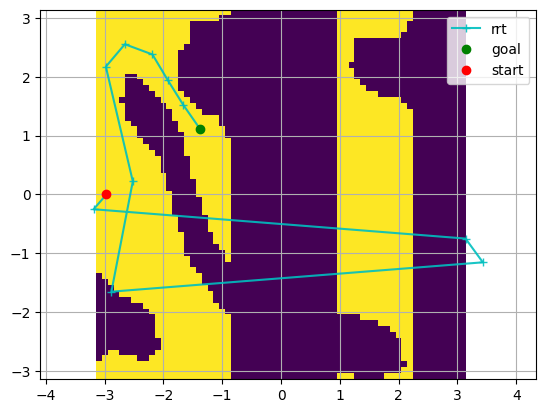

In [50]:
import matplotlib.pyplot as plt
disp_path = final_path.copy()
disp_path[disp_path > np.pi] = 2 * np.pi - disp_path[disp_path > np.pi]
disp_path[disp_path < -np.pi] = 2 * np.pi + disp_path[disp_path < -np.pi]

plt.plot(final_path[:, 0], final_path[:, 1], "c-+", alpha=0.9, label="rrt")
plt.plot(final_path[-1, 0], final_path[-1, 1], "go", label="goal")
plt.plot(final_path[0, 0], final_path[0, 1], "ro", label="start")
plt.grid()
plt.legend()
obstacle_viz = 1-results.copy()
# obstacle_viz[obstacle_viz==0.] = np.nan
plt.imshow(obstacle_viz, extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.axis("equal")